<a href="https://colab.research.google.com/github/vimalkumarasamy/computer_vision/blob/master/CV_Task2_OCR_NCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
cd /content/gdrive/My Drive/Computer_Vision

/content/gdrive/My Drive/Computer_Vision


In [0]:
import argparse
import copy
import os
import cv2
import numpy as np
import utils
from task1 import *

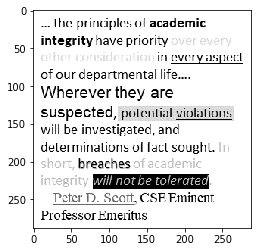

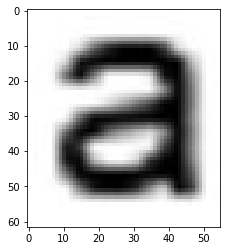

In [19]:
# Importing the image and printing it on the console
img=read_image('proj1-task2-png.png')
template=read_image('a.jpg')
plt.imshow(img, cmap="gray")
plt.show()
plt.imshow(template, cmap="gray")
plt.show()

In [0]:
# Prewitt operator
prewitt_x = [[1, 0, -1]] * 3
prewitt_y = [[1] * 3, [0] * 3, [-1] * 3]
# Sobel operator
sobel_x = [[1, 0, -1], [2, 0, -2], [1, 0, -1]]
sobel_y = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

def parse_args():
    parser = argparse.ArgumentParser(description="cse 473/573 project 1.")
    parser.add_argument(
        "--img_path", type=str, default="",
        help="path to the image used for edge detection")
    parser.add_argument(
        "--kernel", type=str, default="sobel",
        choices=["prewitt", "sobel", "Prewitt", "Sobel"],
        help="type of edge detector used for edge detection")
    parser.add_argument(
        "--result_saving_directory", dest="rs_directory", type=str, default="./results/",
        help="directory to which results are saved (do not change this arg)")
    args = parser.parse_args()
    return args


def read_image(img_path, show=False):
    """Reads an image into memory as a grayscale array.
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if not img.dtype == np.uint8:
        pass

    if show:
        show_image(img)

    img = [list(row) for row in img]
    return img

def show_image(img, delay=1000):
    """Shows an image.
    """
    cv2.namedWindow('image', cv2.WINDOW_AUTOSIZE)
    cv2.imshow('image', img)
    cv2.waitKey(delay)
    cv2.destroyAllWindows()

def write_image(img, img_saving_path):
    """Writes an image to a given path.
    """
    if isinstance(img, list):
        img = np.asarray(img, dtype=np.uint8)
    elif isinstance(img, np.ndarray):
        if not img.dtype == np.uint8:
            assert np.max(img) <= 1, "Maximum pixel value {:.3f} is greater than 1".format(np.max(img))
            img = (255 * img).astype(np.uint8)
    else:
        raise TypeError("img is neither a list nor a ndarray.")

In [0]:
def hogs(img):
  import math
  import numpy as np
  hogs_x=[-1,1]
  hogs_img_x=copy.deepcopy(img)
  hogs_grad_x=copy.deepcopy(img)
  for i in range(len(hogs_img_x)):
    hogs_img_x[i]=hogs_img_x[i]+[0]
  hogs_y=[1,-1]
  hogs_img_y=copy.deepcopy(img)
  hogs_grad_y=copy.deepcopy(img)
  hogs_img_y=hogs_img_y+(np.zeros((1, len(hogs_img_y[0]))).tolist())

  for i in range(len(img)):
    for j in range(len(img[0])):
      hogs_grad_x[i][j]=(hogs_img_x[i][j]*hogs_x[0])+(hogs_img_x[i][j+1]*hogs_x[1])
      hogs_grad_y[i][j]=(hogs_img_y[i][j]*hogs_y[0])+(hogs_img_y[i+1][j]*hogs_y[1])
  hogs_grad=copy.deepcopy(img)
  hogs_hist=np.zeros(8).tolist()
  for i in range(len(hogs_grad)):
    for j in range(len(hogs_grad[0])):
      R=abs(hogs_grad_y[i][j]/(hogs_grad_x[i][j]+0.000000000001))
      if hogs_grad_x[i][j]<0 and hogs_grad_y[i][j]>=0:
        hogs_grad[i][j]=(math.pi-(math.atan(R)))//(math.pi/4)
        hogs_hist[int((math.pi-(math.atan(R)))//(math.pi/4))]+=1
      elif hogs_grad_x[i][j]>=0 and hogs_grad_y[i][j]<0:
        hogs_grad[i][j]=((2*math.pi)-(math.atan(R)) )//(math.pi/4)
        hogs_hist[int(((2*math.pi)-(math.atan(R)) )//(math.pi/4))]+=1
      elif hogs_grad_x[i][j]<0 and hogs_grad_y[i][j]<0:
        hogs_grad[i][j]=(math.pi+(math.atan(R)))//(math.pi/4)
        hogs_hist[int((math.pi+(math.atan(R)))//(math.pi/4))]+=1
      else:
        hogs_grad[i][j]=(math.atan(R))//(math.pi/4)
        hogs_hist[int((math.atan(R))//(math.pi/4))]+=1
  s=sum(hogs_hist)     
  hogs_hist_per=[i/s for i in hogs_hist]
  return(hogs_hist_per)


In [0]:
def euclidean(arr1,arr2):
  summ=0
  for i in range(len(arr1)):
    summ+=(arr1[i]-arr2[i])**2
  return summ**0.5

In [0]:
def match_template(img,template):
  # t_l=len(template)
  # t_b=len(template[0])
  t_l=12
  t_b=12
  i_l=len(img)
  i_b=len(img[0])
  hogs_match=np.zeros((i_l-t_l,i_b-t_b)).tolist()
  hogs_template=hogs(template)
  img_np=np.array(img)
  for i in range(i_l-t_l):
    for j in range(i_b-t_b):
      hogs_match[i][j]=euclidean(hogs(img_np[i:i+t_l,j:j+t_b].tolist()),hogs_template)
  return(hogs_match)    

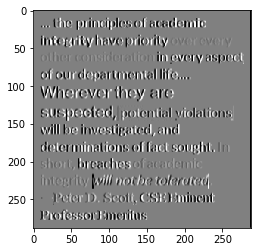

In [94]:
# edges=edge_magnitude(detect_edges(img, sobel_x, norm=False),detect_edges(img, sobel_y, norm=False))
edges_img=detect_edges(img, sobel_x, norm=False)
plt.imshow(edges_img, cmap="gray")
plt.show()

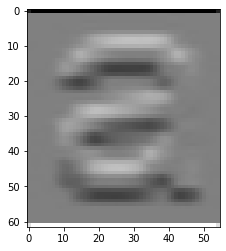

In [95]:
edges_temp=detect_edges(template, sobel_y, norm=False)
plt.imshow(edges_temp, cmap="gray")
plt.show()

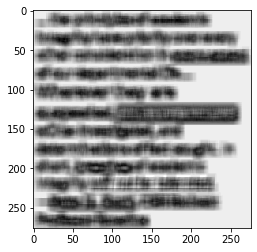

In [104]:
a_match=match_template(img,template)
plt.imshow(normalize(a_match), cmap="gray")
plt.show()

In [105]:
mx=10000
for i in range(len(a_match)):
  for j in range(len(a_match[0])):
    if a_match[i][j]<mx:
      mx=a_match[i][j]
      l,b=i,j
print(mx,l,b)

0.058907882450779 37 39


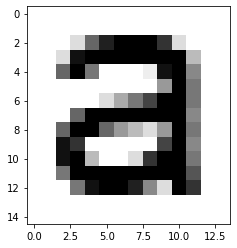

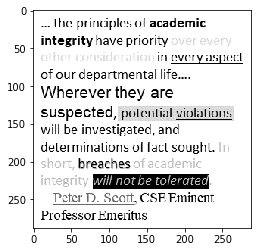

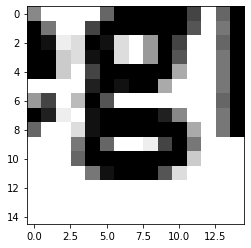

In [106]:
# template dimensions
# 62,55
plt.imshow(np.array(img)[103:103+15,154:154+14].tolist(), cmap="gray")
plt.show()
plt.imshow(img, cmap="gray")
plt.show()

plt.imshow(np.array(img)[37:37+15,39:39+15].tolist(), cmap="gray")
plt.show()




In [0]:
def correlation_coefficient(patch1, patch2):
    product = np.mean((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    stds = patch1.std() * patch2.std()
    if stds == 0:
        return 0
    else:
        product /= stds
        return product
  
def ncc(image,temp):
  import numpy as np
  t_np=np.array(temp)
  i_np=np.array(image)
  t_np=t_np/t_np.sum()
  i_l=len(image)
  i_b=len(image[0])
  t_l=len(temp)
  t_b=len(temp[0])
  ncc_mat=np.zeros((i_l-t_l+1,i_b-t_b+1)).tolist()
  for i in range(i_l-t_l+1):
    for j in range(i_b-t_b+1):
      ncc_mat[i][j]=correlation_coefficient(i_np[i:i+t_l,j:j+t_b],t_np)
  return(ncc_mat)

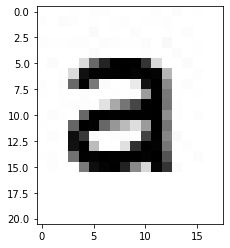

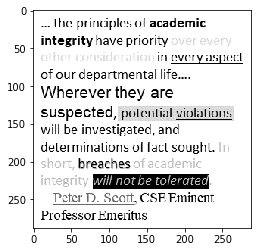

In [169]:
a=read_image('a_new.jpg')
plt.imshow(a, cmap="gray")
plt.show()

img=read_image('proj1-task2-png.png')
plt.imshow(img,cmap="gray")
plt.show()

In [0]:
edges_a=detect_edges(a, sobel_y, norm=False)
edges_img=detect_edges(img, sobel_y, norm=False)

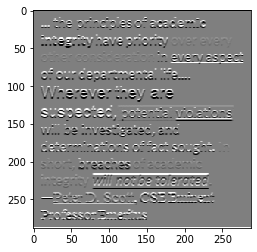

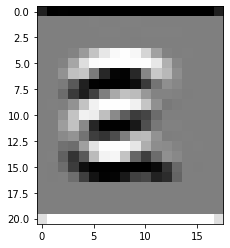

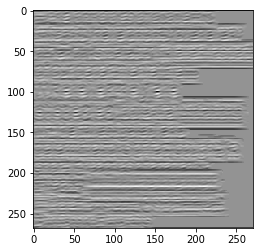

In [170]:
plt.imshow(normalize(edges_img),cmap="gray")
plt.show()
plt.imshow(normalize(edges_a),cmap="gray")
plt.show()
ncc_a=ncc(edges_img,edges_a)
plt.imshow(ncc_a,cmap="gray")
plt.show()

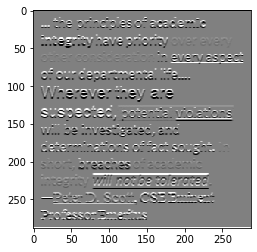

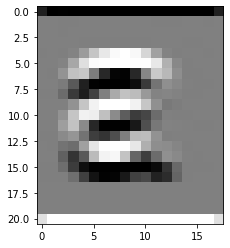

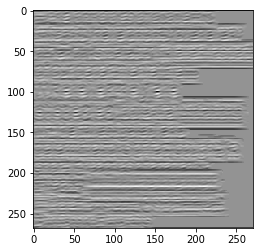

In [171]:
plt.imshow(edges_img,cmap="gray")
plt.show()
plt.imshow(edges_a,cmap="gray")
plt.show()
ncc_a=ncc(edges_img,edges_a)
plt.imshow(ncc_a,cmap="gray")
plt.show()

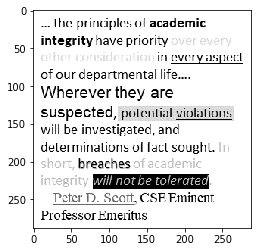

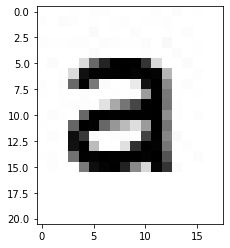

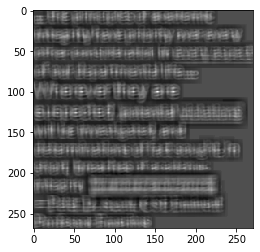

In [172]:
plt.imshow(img,cmap="gray")
plt.show()
plt.imshow(a,cmap="gray")
plt.show()
ncc_a=ncc(img,a)
plt.imshow(ncc_a,cmap="gray")
plt.show()